In [1]:
from i308_calib import *
from i308_utils import *
import cv2
import pickle
import sys
import os
import matplotlib.pyplot as plt
# import stereodemo
import json
import numpy as np
# import open3d as o3d

sys.path.append(os.path.abspath(os.path.join("..", "src")))
from calib_funcs import *
from rect_funcs import *
from pnp_funcs import *

%load_ext autoreload
%autoreload 2

In [2]:
with open("../datasets/budha_board/calibration_results/stereo_calibration.pkl", "rb") as f:
    calibration_results = pickle.load(f)

In [3]:
with open("../datasets/budha_board/rectification_results/stereo_rectification.pkl", "rb") as f:
    rectification_results = pickle.load(f)

In [4]:
with open("../datasets/budha_board/depths/depths.pkl", "rb") as f:
    depths = pickle.load(f)

In [5]:
with open("../datasets/budha_board/poses/poses.pkl", "rb") as f:
    poses = pickle.load(f)

In [6]:
with open("../datasets/budha_board/disparities/disparities.pkl", "rb") as f:
    disparities = pickle.load(f)

In [7]:
print(calibration_results.keys())
print(rectification_results.keys())
print(depths.keys())
print(poses.keys())

dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])
dict_keys(['R1', 'R2', 'P1', 'P2', 'Q', 'validRoi1', 'validRoi2', 'left_map_x', 'left_map_y', 'right_map_x', 'right_map_y'])
dict_keys(['depths', 'depths_clipped'])
dict_keys([0, 1, 2, 3, 4, 5])


In [8]:
dir = "../datasets/budha_board/rectified_captures"
left_imgs, right_imgs = get_images(dir, prefix="", ext="jpg", print_info=True)

Found 6 left images and 6 right images
First left image: ..\datasets\budha_board\rectified_captures\left_rectified_0.jpg
First right image: ..\datasets\budha_board\rectified_captures\right_rectified_0.jpg


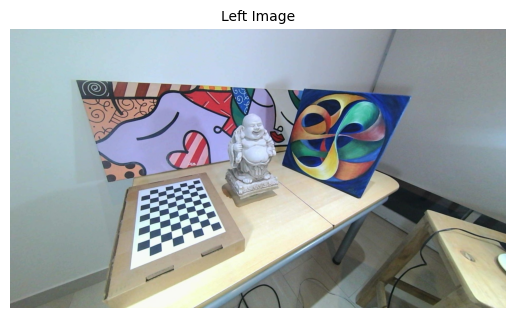

In [9]:
imshow(left_imgs[0], "Left Image")

FALTA ESTA PARTE!

In [10]:
disparities = disparities['disparities']

In [11]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [12]:

all_world_points = []
for i in range(6):
    disparity = disparities[i]
    Q = rectification_results["Q"]
    o_T_c = poses[i]
    points_3d = cv2.reprojectImageTo3D(disparity, Q)
    points_3d_flat = points_3d.reshape(-1, 3) 
    homo_points_3d = np.concatenate([points_3d_flat, np.ones((points_3d_flat.shape[0], 1))], axis=1)
    points_world = (o_T_c @ homo_points_3d.T).T[:, :3]

    all_world_points.append(points_world)
    #show points

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_world)
    o3d.visualization.draw_geometries([pcd])



In [34]:
all_world_points = []
all_colors = []
for i in range(6):
    disparity = disparities[i]
    Q = rectification_results["Q"]
    o_T_c = poses[i]

    # Imágenes rectificadas
    rectified_left_image = left_imgs[i]  # Debes tener esta imagen cargada y en formato BGR

    # Reconstruir la nube de puntos 3D
    points_3d = cv2.reprojectImageTo3D(disparity, Q)
    points_3d_flat = points_3d.reshape(-1, 3)

    # Homogeneizar
    homo_points_3d = np.concatenate([points_3d_flat, np.ones((points_3d_flat.shape[0], 1))], axis=1)
    points_world = (o_T_c @ homo_points_3d.T).T[:, :3]

    # Obtener los colores
    colors = rectified_left_image.reshape(-1, 3) / 255.0  # Normalizar los colores a [0, 1]

    # Filtrar puntos inválidos (disparidad <= 0 o muy lejana)
    valid_mask = (disparity.flatten() > 0) & (points_3d_flat[:, 2] < 10000)
    points_world = points_world[valid_mask]
    colors = colors[valid_mask]

    all_world_points.append(points_world)
    all_colors.append(colors)

    # # Crear la nube de puntos con colores
    if i == -1:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points_world)
        pcd.colors = o3d.utility.Vector3dVector(colors)

        # Mostrar la nube de puntos
        o3d.visualization.draw_geometries([pcd])


In [37]:
all_world_points2 = []
all_colors2 = []

for i in range(1):
    disparity = disparities[i]
    Q = rectification_results["Q"]
    o_T_c = poses[i]

    # Imágenes rectificadas
    rectified_left_image = left_imgs[i]

    # Reconstruir la nube de puntos 3D
    points_3d = cv2.reprojectImageTo3D(disparity, Q)
    points_3d_flat = points_3d.reshape(-1, 3)

    # Colores
    colors = rectified_left_image.reshape(-1, 3) / 255.0

    # Máscara para puntos válidos
    valid_mask = (disparity.flatten() > 0) & (points_3d_flat[:, 2] < 10000)
    points_3d_flat = points_3d_flat[valid_mask]
    colors = colors[valid_mask]

    # Crear PointCloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3d_flat)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # Transformar
    pcd.transform(o_T_c)

    # Guardar puntos y colores
    all_world_points2.append(points_3d_flat)
    all_colors2.append(colors)

    # Mostrar con ejes
    axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=28)
    o3d.visualization.draw_geometries([pcd, axis])


In [29]:
center = np.array([0, 0, 0])
R = np.eye(3)
extent = np.array([1000, 1000, 1000])


box = o3d.geometry.OrientedBoundingBox(center=center, R=R, extent=extent)

indices_in_box = box.get_point_indices_within_bounding_box(pcd.points)
pcd = pcd.select_by_index(indices_in_box)
nbn = 8
std_ratio = 2.0
pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=nbn, std_ratio=std_ratio)
o3d.io.write_point_cloud("my-pcd.ply", pcd)

True

In [ ]:
points = np.vstack(all_world_points)
colors = np.vstack(all_colors)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)
center = np.array([0, 0, 0])
R = np.eye(3)
extent = np.array([900, 900, 900])


box = o3d.geometry.OrientedBoundingBox(center=center, R=R, extent=extent)

indices_in_box = box.get_point_indices_within_bounding_box(pcd.points)
pcd = pcd.select_by_index(indices_in_box)
nbn = 10
std_ratio = 1
pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=nbn, std_ratio=std_ratio)

In [ ]:
path = "../datasets/budha_board/budha.ply"
o3d.io.write_point_cloud(path, pcd)

True

In [15]:
# import numpy as np
# import cv2
# import open3d as o3d

# def transformar_puntos_al_mundo(points_3D, disparity, o_T_c, max_depth=2000):
#     h, w, _ = points_3D.shape
#     mask = (disparity > disparity.min()) & (points_3D[:, :, 2] < max_depth)
#     points_3D_flat = points_3D.reshape(-1, 3)
#     mask_flat = mask.flatten()

#     # Coordenadas homogéneas
#     points_hom = np.hstack((points_3D_flat[mask_flat], np.ones((np.sum(mask_flat), 1))))
#     # Transformar al sistema mundo
#     points_world = (o_T_c @ points_hom.T).T[:, :3]
#     return points_world

# def reconstruir_escena(disparidades, Q, matrices_o_T_c, max_depth=2000):
#     todas_las_nubes = []

#     for disp, o_T_c in zip(disparidades, matrices_o_T_c):
#         puntos_3D = cv2.reprojectImageTo3D(disp, Q)
#         puntos_mundo = transformar_puntos_al_mundo(puntos_3D, disp, o_T_c, max_depth=max_depth)
#         todas_las_nubes.append(puntos_mundo)

#     # Unir y convertir a nube Open3D
#     nube_total = np.vstack(todas_las_nubes)
#     pcd = o3d.geometry.PointCloud()
#     pcd.points = o3d.utility.Vector3dVector(nube_total)

#     # (Opcional) remover outliers
#     pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

#     return pcd

# # Ejemplo de uso (asumimos que ya tenés disparidades, Qs y o_T_cs cargados):
# # pcd = reconstruir_escena(disparidades, matrices_Q, matrices_o_T_c)
# # o3d.visualization.draw_geometries([pcd])
# # o3d.io.write_point_cloud("reconstruccion.ply", pcd)

# reconstruir_escena(disparities, rectification_results["Q"], poses)
